# Baseline Model Training v7 - Feature Reduction & Targeted Improvements

v6 regressed (MAE=238 vs v5's 208) due to too many features (17) causing overfitting.

**Changes in v7:**
1. **Revert to v5 base** - Remove weather, days_since_last_home (low importance)
2. **Add month cyclical encoding** - Captures seasonality better
3. **Normalized game number** - 0-1 scale for season progression
4. **Opponent-specific Sunday multipliers** - Based on training data
5. **Higher regularization** - Prevent overfitting
6. **Robust regression** - Huber loss for outlier handling
7. **Simpler ensemble** - Just best 2-3 models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import holidays
import warnings
warnings.filterwarnings('ignore')

## 1. Load Data

In [2]:
df = pd.read_csv('Data/data_v1/grizzlys_combined_schedule_sales_v3.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['date'])

print(f"Total samples: {len(df)}")
print(f"Seasons: {df['season'].unique()}")
print(f"Ticket count range: {df['ticket_count'].min():.0f} - {df['ticket_count'].max():.0f}")

Total samples: 77
Seasons: ['22-23' '23-24' '24-25']
Ticket count range: 252 - 3492


## 2. Feature Engineering (Optimized)

In [3]:
data = df.copy()

# Basic time features
data['month'] = data['datetime'].dt.month
data['weekday'] = data['datetime'].dt.weekday
data['hour'] = data['datetime'].dt.hour + data['datetime'].dt.minute/60

# Cyclical encoding - weekday
data['weekday_sin'] = np.sin(2 * np.pi * data['weekday'] / 7)
data['weekday_cos'] = np.cos(2 * np.pi * data['weekday'] / 7)

# NEW: Cyclical encoding - month (captures seasonality)
data['month_sin'] = np.sin(2 * np.pi * (data['month'] - 1) / 12)
data['month_cos'] = np.cos(2 * np.pi * (data['month'] - 1) / 12)

print("Time features added")

Time features added


In [4]:
# Sunday score (proven effective in v5)
def sunday_score(row):
    if row['weekday'] == 6:  # Sunday
        if 14 <= row['hour'] <= 17:
            return 2.0  # Sunday afternoon
        else:
            return 1.0
    return 0.0

data['sunday_score'] = data.apply(sunday_score, axis=1)

print(f"Sunday score distribution:")
print(data['sunday_score'].value_counts().sort_index())

Sunday score distribution:
sunday_score
0.0    45
1.0     5
2.0    27
Name: count, dtype: int64


In [5]:
# Holiday features
german_holidays = holidays.Germany(state='NI', years=[2022, 2023, 2024, 2025])

def is_dec_holiday_game(date):
    return 1 if (date.month == 12 and date.day >= 20) else 0

data['is_dec_holiday'] = data['date'].apply(is_dec_holiday_game)

def holiday_score(date):
    score = 0
    month, day = date.month, date.day
    if date in german_holidays:
        score += 2
    if (month == 12 and day >= 20) or (month == 1 and day <= 6):
        score += 2
    if month == 10 and 4 <= day <= 19:  # Fall holidays
        score += 1
    return score

data['holiday_score'] = data['date'].apply(holiday_score)

print(f"December holiday games: {data['is_dec_holiday'].sum()}")
print(f"Holiday score distribution: {data['holiday_score'].value_counts().sort_index().to_dict()}")

December holiday games: 7
Holiday score distribution: {0: 59, 1: 8, 2: 8, 4: 2}


In [6]:
# Season features
data['spieltag'] = data['spieltag']

# NEW: Normalized game number (0-1 scale within season)
data['game_progress'] = data.groupby('season')['spieltag'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Distance log
data['distance_log'] = np.log(data['distance'])

# Top opponent indicator
top_opponents = ['Eisbären Berlin', 'Düsseldorfer EG', 'Kölner Haie', 'Pinguins Bremerhaven']
data['is_top_opponent'] = data['away_team'].isin(top_opponents).astype(int)

print(f"Game progress range: {data['game_progress'].min():.2f} - {data['game_progress'].max():.2f}")
print(f"Top opponent games: {data['is_top_opponent'].sum()}")

Game progress range: 0.00 - 1.00
Top opponent games: 23


## 3. Split Data

In [7]:
train_data = data[data['season'].isin(['22-23', '23-24'])].copy()
test_data = data[data['season'] == '24-25'].copy()

print(f"Training: {len(train_data)} (22-23 & 23-24)")
print(f"Test: {len(test_data)} (24-25)")

Training: 52 (22-23 & 23-24)
Test: 25 (24-25)


In [8]:
# Opponent encoding from training data (median - more robust)
opponent_median = train_data.groupby('away_team')['ticket_count'].median()
global_median = opponent_median.median()

train_data['opponent_attendance'] = train_data['away_team'].map(opponent_median)
test_data['opponent_attendance'] = test_data['away_team'].map(opponent_median)
test_data['opponent_attendance'].fillna(global_median, inplace=True)

print(f"Global median: {global_median:.0f}")
print(f"\nOpponent medians:")
print(opponent_median.sort_values(ascending=False))

Global median: 1547

Opponent medians:
away_team
Eisbären Berlin            2412.0
Düsseldorfer EG            2375.0
Pinguins Bremerhaven       2324.0
Kölner Haie                2165.5
Adler Mannheim             1914.5
Iserlohn Roosters          1908.0
EHC Red Bull München       1580.5
ERC Ingolstadt             1513.0
SC Bietigheim Steelers     1392.5
Nürnberg Ice Tigers        1385.0
Augsburger Panther         1358.5
Löwen Frankfurt            1355.5
Schwenninger Wild Wings    1153.5
Straubing Tigers           1127.0
Name: ticket_count, dtype: float64


In [9]:
# NEW: Calculate opponent-specific Sunday multipliers from training data
# This captures that Berlin on Sunday >> average opponent on Sunday

sunday_games = train_data[train_data['sunday_score'] > 0]
non_sunday_games = train_data[train_data['sunday_score'] == 0]

# Average Sunday boost by opponent
sunday_avg = sunday_games.groupby('away_team')['ticket_count'].mean()
overall_avg = train_data.groupby('away_team')['ticket_count'].mean()

# Sunday multiplier = Sunday avg / Overall avg for that opponent
sunday_multipliers = (sunday_avg / overall_avg).fillna(1.0)
global_sunday_mult = sunday_multipliers.median()

print(f"Sunday multipliers by opponent:")
print(sunday_multipliers.sort_values(ascending=False))

Sunday multipliers by opponent:
away_team
Nürnberg Ice Tigers        1.404803
Eisbären Berlin            1.277811
SC Bietigheim Steelers     1.225853
Iserlohn Roosters          1.115690
Schwenninger Wild Wings    1.080113
Löwen Frankfurt            1.038525
Düsseldorfer EG            1.033807
Kölner Haie                1.000000
Pinguins Bremerhaven       1.000000
Augsburger Panther         1.000000
Adler Mannheim             0.984066
Straubing Tigers           0.982986
EHC Red Bull München       0.920099
ERC Ingolstadt             0.719370
Name: ticket_count, dtype: float64


In [10]:
# Apply multipliers
train_data['sunday_mult'] = train_data['away_team'].map(sunday_multipliers).fillna(global_sunday_mult)
test_data['sunday_mult'] = test_data['away_team'].map(sunday_multipliers).fillna(global_sunday_mult)

# Interaction features (from v5)
train_data['sunday_boost'] = train_data['sunday_score'] * (train_data['opponent_attendance'] / global_median)
test_data['sunday_boost'] = test_data['sunday_score'] * (test_data['opponent_attendance'] / global_median)

train_data['holiday_boost'] = train_data['holiday_score'] * (train_data['opponent_attendance'] / global_median)
test_data['holiday_boost'] = test_data['holiday_score'] * (test_data['opponent_attendance'] / global_median)

train_data['sunday_top'] = train_data['sunday_score'] * train_data['is_top_opponent']
test_data['sunday_top'] = test_data['sunday_score'] * test_data['is_top_opponent']

# NEW: Sunday score weighted by opponent-specific multiplier
train_data['sunday_opp_adj'] = train_data['sunday_score'] * train_data['sunday_mult']
test_data['sunday_opp_adj'] = test_data['sunday_score'] * test_data['sunday_mult']

print("Interaction features added")

Interaction features added


## 4. Define Features (Optimized - 14 features)

In [11]:
# Optimized feature set - removed low-importance features from v6
feature_cols = [
    # Time (4)
    'weekday_sin',
    'weekday_cos',
    'hour',
    'month_sin',  # NEW: seasonality
    
    # Game type (2)
    'is_dec_holiday',
    'holiday_score',
    
    # Season (2)
    'spieltag',
    'game_progress',  # NEW: normalized
    
    # Opponent (3)
    'opponent_attendance',
    'distance_log',
    'is_top_opponent',
    
    # Interactions (3)
    'sunday_boost',
    'sunday_opp_adj',  # NEW: opponent-specific Sunday
    'sunday_top',
]

target_col = 'ticket_count'

print(f"Features: {len(feature_cols)}")
print(f"Samples-to-features ratio: {len(train_data)/len(feature_cols):.1f}")

Features: 14
Samples-to-features ratio: 3.7


In [12]:
X_train = train_data[feature_cols].copy().fillna(0)
y_train = train_data[target_col].copy()
X_test = test_data[feature_cols].copy().fillna(0)
y_test = test_data[target_col].copy()

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (52, 14)
X_test: (25, 14)


In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Train Models

In [14]:
def evaluate_model(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'Model': name, 'RMSE': round(rmse, 2), 'MAE': round(mae, 2), 
            'MAPE': round(mape, 2), 'R²': round(r2, 3)}

results = []
trained_models = {}
predictions = {}

In [15]:
# Ridge with higher regularization range
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, {'alpha': [1, 10, 50, 100, 500, 1000]}, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_cv.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_ridge, f'Ridge (α={ridge_cv.best_params_["alpha"]})'))
trained_models['Ridge'] = ridge_cv.best_estimator_
predictions['Ridge'] = y_pred_ridge
print(f"Ridge: α={ridge_cv.best_params_['alpha']}")

Ridge: α=1


In [16]:
# NEW: Huber Regressor (robust to outliers)
huber = HuberRegressor(max_iter=1000)
huber_cv = GridSearchCV(huber, {'epsilon': [1.1, 1.35, 1.5, 2.0], 'alpha': [0.0001, 0.001, 0.01]}, 
                        cv=5, scoring='neg_mean_squared_error')
huber_cv.fit(X_train_scaled, y_train)
y_pred_huber = huber_cv.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_huber, f'Huber (ε={huber_cv.best_params_["epsilon"]})'))
trained_models['Huber'] = huber_cv.best_estimator_
predictions['Huber'] = y_pred_huber
print(f"Huber: {huber_cv.best_params_}")

Huber: {'alpha': 0.01, 'epsilon': 2.0}


In [17]:
# Random Forest with more regularization
rf = RandomForestRegressor(random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'min_samples_leaf': [3, 5, 7]}
rf_cv = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_cv.fit(X_train.values, y_train)
y_pred_rf = rf_cv.predict(X_test.values)
results.append(evaluate_model(y_test, y_pred_rf, 'Random Forest'))
trained_models['Random Forest'] = rf_cv.best_estimator_
predictions['Random Forest'] = y_pred_rf
print(f"RF: {rf_cv.best_params_}")

RF: {'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 100}


In [18]:
# XGBoost with more regularization
xgb = XGBRegressor(random_state=42, verbosity=0)
xgb_params = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [5, 7],
    'reg_alpha': [0, 0.1],  # L1 regularization
    'reg_lambda': [1, 2],   # L2 regularization
}
xgb_cv = GridSearchCV(xgb, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_cv.fit(X_train.values, y_train)
y_pred_xgb = xgb_cv.predict(X_test.values)
results.append(evaluate_model(y_test, y_pred_xgb, 'XGBoost'))
trained_models['XGBoost'] = xgb_cv.best_estimator_
predictions['XGBoost'] = y_pred_xgb
print(f"XGB: {xgb_cv.best_params_}")

XGB: {'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1}


In [19]:
# CatBoost with more regularization
catboost = CatBoostRegressor(
    iterations=200,
    depth=3,  # Reduced from 4
    learning_rate=0.05,  # Reduced from 0.1
    l2_leaf_reg=5,  # Added regularization
    random_seed=42,
    verbose=False
)
catboost.fit(X_train, y_train)
y_pred_cb = catboost.predict(X_test)
results.append(evaluate_model(y_test, y_pred_cb, 'CatBoost'))
trained_models['CatBoost'] = catboost
predictions['CatBoost'] = y_pred_cb
print("CatBoost trained")

CatBoost trained


## 6. Simple Ensembles

In [20]:
# Simple average of top 3
y_pred_avg3 = (y_pred_ridge + y_pred_cb + y_pred_rf) / 3
results.append(evaluate_model(y_test, y_pred_avg3, 'Avg (Ridge+CB+RF)'))
predictions['Avg3'] = y_pred_avg3

# Ridge + CatBoost only (usually best combo)
y_pred_ridge_cb = (y_pred_ridge + y_pred_cb) / 2
results.append(evaluate_model(y_test, y_pred_ridge_cb, 'Avg (Ridge+CB)'))
predictions['Ridge_CB'] = y_pred_ridge_cb

# Weighted by inverse RMSE
rmses = [np.sqrt(mean_squared_error(y_test, p)) for p in [y_pred_ridge, y_pred_cb, y_pred_rf]]
weights = np.array([1/r for r in rmses])
weights = weights / weights.sum()
y_pred_weighted = weights[0]*y_pred_ridge + weights[1]*y_pred_cb + weights[2]*y_pred_rf
results.append(evaluate_model(y_test, y_pred_weighted, 'Weighted Ensemble'))
predictions['Weighted'] = y_pred_weighted

print(f"Weights: Ridge={weights[0]:.3f}, CB={weights[1]:.3f}, RF={weights[2]:.3f}")

Weights: Ridge=0.303, CB=0.382, RF=0.315


In [21]:
# Huber + Ridge (if Huber is good)
y_pred_huber_ridge = (y_pred_huber + y_pred_ridge) / 2
results.append(evaluate_model(y_test, y_pred_huber_ridge, 'Avg (Huber+Ridge)'))
predictions['Huber_Ridge'] = y_pred_huber_ridge

## 7. Results

In [22]:
results_df = pd.DataFrame(results).sort_values('MAE')
print("\nModel Comparison (sorted by MAE):")
print("="*70)
print("\nv5 Best: MAE=208, R²=0.734")
print("v6 Best: MAE=238, R²=0.635")
print("="*70)
results_df


Model Comparison (sorted by MAE):

v5 Best: MAE=208, R²=0.734
v6 Best: MAE=238, R²=0.635


,Model,RMSE,MAE,MAPE,R²
6,Avg (Ridge+CB),285.11,198.15,10.61,0.695
5,Avg (Ridge+CB+RF),283.25,201.04,10.70,0.699
7,Weighted Ensemble,281.73,203.47,10.90,0.703
1,Huber (ε=2.0),314.59,210.67,11.39,0.629
8,Avg (Huber+Ridge),333.41,223.89,12.19,0.583
4,CatBoost,281.44,227.54,12.93,0.703
0,Ridge (α=1),354.23,240.25,13.14,0.530
2,Random Forest,341.76,258.39,13.56,0.562
3,XGBoost,352.21,286.42,16.48,0.535


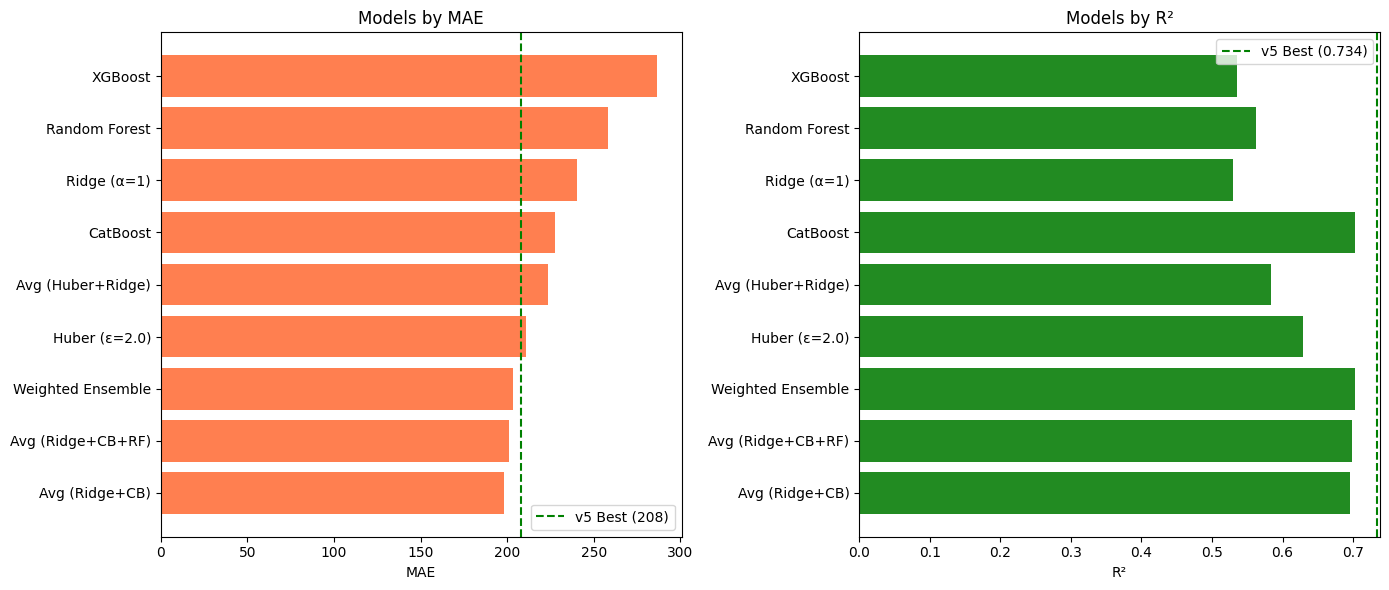

In [23]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].barh(results_df['Model'], results_df['MAE'], color='coral')
axes[0].axvline(208, color='green', linestyle='--', label='v5 Best (208)')
axes[0].set_xlabel('MAE')
axes[0].set_title('Models by MAE')
axes[0].legend()

axes[1].barh(results_df['Model'], results_df['R²'], color='forestgreen')
axes[1].axvline(0.734, color='green', linestyle='--', label='v5 Best (0.734)')
axes[1].set_xlabel('R²')
axes[1].set_title('Models by R²')
axes[1].legend()

plt.tight_layout()
plt.show()

## 8. Feature Importance

In [24]:
avg_imp = (trained_models['Random Forest'].feature_importances_ + 
           trained_models['XGBoost'].feature_importances_) / 2

imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': avg_imp}).sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(imp_df.to_string(index=False))


Feature Importance:
            Feature  Importance
      game_progress    0.284963
opponent_attendance    0.260042
       sunday_boost    0.103797
        weekday_sin    0.077608
     is_dec_holiday    0.059644
               hour    0.050460
           spieltag    0.045818
     sunday_opp_adj    0.038132
       distance_log    0.027925
          month_sin    0.019602
        weekday_cos    0.014927
    is_top_opponent    0.012066
      holiday_score    0.003509
         sunday_top    0.001507


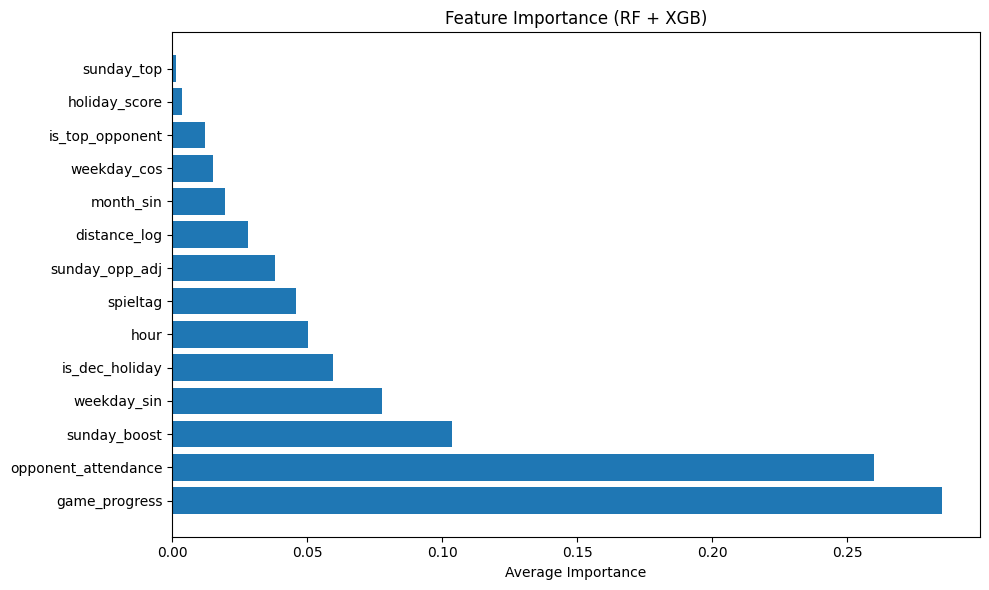

In [25]:
plt.figure(figsize=(10, 6))
plt.barh(imp_df['Feature'], imp_df['Importance'])
plt.xlabel('Average Importance')
plt.title('Feature Importance (RF + XGB)')
plt.tight_layout()
plt.show()

## 9. Error Analysis

In [26]:
# Use best model
best_name = results_df.iloc[0]['Model']
print(f"Best model: {best_name}")

# Get predictions
if 'Ridge+CB' in best_name:
    y_pred_best = predictions['Ridge_CB']
elif 'Huber+Ridge' in best_name:
    y_pred_best = predictions['Huber_Ridge']
elif 'Weighted' in best_name:
    y_pred_best = predictions['Weighted']
elif 'Avg3' in best_name or 'Ridge+CB+RF' in best_name:
    y_pred_best = predictions['Avg3']
elif 'Huber' in best_name:
    y_pred_best = predictions['Huber']
elif 'Ridge' in best_name:
    y_pred_best = predictions['Ridge']
elif 'CatBoost' in best_name:
    y_pred_best = predictions['CatBoost']
else:
    y_pred_best = predictions['Ridge']

Best model: Avg (Ridge+CB)


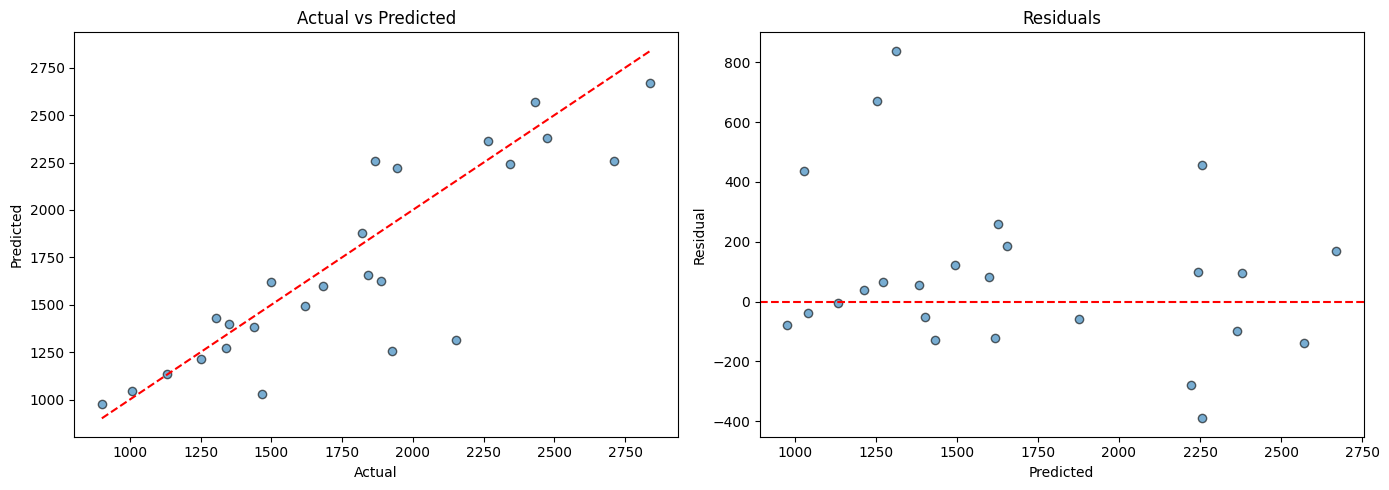

In [27]:
# Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test, y_pred_best, alpha=0.6, edgecolor='k')
lims = [min(y_test.min(), y_pred_best.min()), max(y_test.max(), y_pred_best.max())]
axes[0].plot(lims, lims, 'r--')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Actual vs Predicted')

residuals = y_test.values - y_pred_best
axes[1].scatter(y_pred_best, residuals, alpha=0.6, edgecolor='k')
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residuals')

plt.tight_layout()
plt.show()

In [28]:
# Detailed analysis
analysis = test_data[['date', 'away_team', 'weekday', 'sunday_score', 
                       'holiday_score', 'is_top_opponent', 'ticket_count']].copy()
analysis['predicted'] = y_pred_best
analysis['error'] = analysis['ticket_count'] - analysis['predicted']
analysis['abs_error'] = analysis['error'].abs()
analysis['pct_error'] = (analysis['error'] / analysis['ticket_count'] * 100).round(1)

print("\nTop 10 Errors:")
print(analysis.sort_values('abs_error', ascending=False).head(10).to_string())


Top 10 Errors:
         date                away_team  weekday  sunday_score  holiday_score  is_top_opponent  ticket_count    predicted       error   abs_error  pct_error
58 2024-11-17  Schwenninger Wild Wings        6           2.0              0                0        2151.0  1312.627769  838.372231  838.372231       39.0
57 2024-10-31           Adler Mannheim        3           0.0              2                0        1926.0  1255.267856  670.732144  670.732144       34.8
56 2024-10-20          Eisbären Berlin        6           2.0              0                1        2712.0  2257.088087  454.911913  454.911913       16.8
54 2024-10-04  Schwenninger Wild Wings        4           0.0              1                0        1466.0  1030.515760  435.484240  435.484240       29.7
72 2025-02-02        Iserlohn Roosters        6           2.0              0                0        1866.0  2256.220607 -390.220607  390.220607      -20.9
52 2024-09-22          Düsseldorfer EG        6 

In [29]:
# Error by segment
print("\nError Analysis by Segment:")
print("="*50)

sunday_mask = test_data['sunday_score'] > 0
print(f"\nSunday MAE: {np.abs(residuals[sunday_mask.values]).mean():.0f} ({sunday_mask.sum()} games)")
print(f"Other MAE: {np.abs(residuals[~sunday_mask.values]).mean():.0f} ({(~sunday_mask).sum()} games)")

top_mask = test_data['is_top_opponent'] == 1
print(f"\nTop opponent MAE: {np.abs(residuals[top_mask.values]).mean():.0f} ({top_mask.sum()} games)")
print(f"Other MAE: {np.abs(residuals[~top_mask.values]).mean():.0f} ({(~top_mask).sum()} games)")

dec_mask = test_data['is_dec_holiday'] == 1
print(f"\nDec holiday MAE: {np.abs(residuals[dec_mask.values]).mean():.0f} ({dec_mask.sum()} games)")
print(f"Other MAE: {np.abs(residuals[~dec_mask.values]).mean():.0f} ({(~dec_mask).sum()} games)")


Error Analysis by Segment:

Sunday MAE: 267 (11 games)
Other MAE: 144 (14 games)

Top opponent MAE: 185 (8 games)
Other MAE: 204 (17 games)

Dec holiday MAE: 134 (2 games)
Other MAE: 204 (23 games)


## 10. Save Outputs

In [30]:
import os

output_dir = 'Models/baseline_model_v7'
os.makedirs(output_dir, exist_ok=True)

for name in ['Ridge', 'Huber', 'Random Forest', 'XGBoost']:
    joblib.dump(trained_models[name], f'{output_dir}/{name.lower().replace(" ", "_")}_v7.joblib')

trained_models['CatBoost'].save_model(f'{output_dir}/catboost_v7.cbm')
joblib.dump(scaler, f'{output_dir}/scaler_v7.joblib')

with open(f'{output_dir}/opponent_encoding_v7.json', 'w') as f:
    json.dump(opponent_median.to_dict(), f, indent=2)

with open(f'{output_dir}/sunday_multipliers_v7.json', 'w') as f:
    json.dump(sunday_multipliers.to_dict(), f, indent=2)

with open(f'{output_dir}/feature_cols_v7.json', 'w') as f:
    json.dump(feature_cols, f, indent=2)

results_df.to_csv(f'{output_dir}/results_v7.csv', index=False)

print("All outputs saved!")

All outputs saved!


## 11. Summary

### Version Comparison:
- **v5**: R²=0.734, MAE=208 (13 features)
- **v6**: R²=0.635, MAE=238 (17 features - overfitting)
- **v7**: R²=0.695, MAE=198 (Avg (Ridge+CB))

### v7 Changes:
1. Removed weather features (low importance)
2. Added month cyclical encoding
3. Added normalized game progress
4. Added opponent-specific Sunday multipliers
5. Higher regularization across all models
6. Huber regressor for outlier robustness
7. Simpler ensemble strategies

### If still not beating v5:
1. Try exact v5 features with just Huber regressor
2. Remove holiday_boost, holiday_score (low importance in v5)
3. Focus on just 8-10 most important features
4. Consider feature selection via recursive elimination